# Load Required Packages

In [2]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(coloc))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(R.utils))
suppressPackageStartupMessages(library(remotes))
suppressPackageStartupMessages(library(tryCatchLog))
suppressPackageStartupMessages(library(qqman))
suppressPackageStartupMessages(library(Rfast))
suppressPackageStartupMessages(library(susieR))
suppressPackageStartupMessages(library(arrow))

# Run coloc

In [68]:
peaks <- list.files('/UKB-PPP/coloc/Peaks/', pattern ='.tsv')

In [92]:
celltypes <- list.files('/GTEx/GTEx_Analysis_v8_EUR_eQTL_all_associations/', pattern='.parquet')
celltypes <- as.data.frame(str_split_fixed(celltypes, '.v8', n=2))$V1
celltypes <- unique(celltypes)

In [1]:
result_table <- data.frame()
result_table2 <- data.frame()
for (x in celltypes){
    
    eqtl <- read_parquet(paste0('/GTEx/GTEx_Analysis_v8_EUR_eQTL_all_associations/',x, '.v8.EUR.allpairs.chr4.parquet'))
    eqtl <- as.data.frame(eqtl)
    
    gene_eqtl <- eqtl[grep('ENSG00000163956', eqtl$phenotype_id),] #ENSEMBL ID for LRPAP1
    gene_eqtl$variant_id <- gsub('_b38', '', gene_eqtl$variant_id)
    gene_eqtl$variant_id <- gsub('chr', '', gene_eqtl$variant_id)
    gene_eqtl$variant_id <- gsub('_', ':', gene_eqtl$variant_id)
    gene_eqtl$CHR <- as.data.frame(str_split_fixed(gene_eqtl$variant_id, ':', n=4))$V1
    gene_eqtl$POS <- as.data.frame(str_split_fixed(gene_eqtl$variant_id, ':', n=4))$V2
    gene_eqtl$REF <- as.data.frame(str_split_fixed(gene_eqtl$variant_id, ':', n=4))$V3
    gene_eqtl$ALT <- as.data.frame(str_split_fixed(gene_eqtl$variant_id, ':', n=4))$V4
    gene_eqtl$CHR <- as.integer(gene_eqtl$CHR)
    gene_eqtl$POS <- as.integer(gene_eqtl$POS)
    gene_eqtl <- gene_eqtl[!is.na(gene_eqtl$pval),]
    gene_eqtl <- gene_eqtl[which(gene_eqtl$slope != Inf),]
    gene_eqtl <- gene_eqtl[which(gene_eqtl$slope != -Inf),]
    
    peaks2 <- peaks[grep('LRPAP1_4_', peaks)]

    for (i in peaks2){
        setwd('/UKB-PPP/coloc/Peaks/')
        peak_name <- sub('.tsv', '', i)
        snp_list <- fread(paste0(peak_name, '.txt'),header = FALSE)
        snp_list2 <- snp_list$V1
        snp_list3 <- gsub('chr', '', snp_list2)
        snp_list3 <- gsub('_', ':', snp_list3)

        peak_protein_name <- str_split_fixed(peak_name, '_', n=4)[1]
        peak_protein_name <- paste0(peak_protein_name, '_')

        all_proteins <- list.files('/UKB-PPP/', pattern = 'all_chr.tsv.gz')

        protein0 <- grep(paste0('\\b',peak_protein_name), all_proteins, value = TRUE)

        if (length(protein0) == 1){
            protein <- fread(paste0('/UKB-PPP/', protein0))
            protein_subset <- fread(paste0(peak_name, '.tsv'))

            eqtl_sumstats <- gene_eqtl[which(gene_eqtl$variant_id %in% snp_list3),] #######

            if (nrow(eqtl_sumstats)>0){

                protein_subset$alleles <- apply(protein_subset[,c('ALLELE1', 'ALLELE0')], 1, function(x) paste(x[order(x)], collapse=''))
                eqtl_sumstats$alleles <- apply(eqtl_sumstats[,c('ALT', 'REF')], 1, function(x) paste(x[order(x)], collapse=''))

                m <- merge(eqtl_sumstats,protein_subset, by.x=c('CHR', 'POS', 'alleles'), by.y=c('CHROM', 'GENPOS', 'alleles'))
                m <- m[!duplicated(m$variant_id),]

                m$eqtl_maf <- sapply(m$maf, function(x) min(c(x, 1-x)))
                m$eqtl_flip <- m$maf < 0.5
                m$eqtl_beta_alt <- m$slope*(c(-1,1)[m$eqtl_flip +1])
                m$protein_maf <- sapply(m$A1FREQ, function(x) min(c(x, 1-x)))
                m$protein_flip <- m$A1FREQ < 0.5
                m$protein_beta_alt <- m$BETA*(c(-1,1)[m$protein_flip +1]) 

                m <-m[!(m$eqtl_maf == 0),]
                m <-m[!(m$maf == 0),]
                m <-m[!(m$protein_maf == 1),]
                m <-m[!(m$A1FREQ == 1),]
                m <-m[!(m$P_VALUE == 0),]
                m <-m[!(m$pval_nominal == 0),]
                                        
                m$N_eqtl <- round(((((1-m$maf)/m$maf)*m$ma_count) + m$ma_count)/2)

                eqtl_dataset = list(beta = m$eqtl_beta_alt,
                        varbeta = m$slope_se^2,
                          type = 'quant',
                          snp = m$variant_id,
                          MAF = m$eqtl_maf,
                          N=m$N_eqtl)

                protein_dataset = list(varbeta = m$SE^2, 
                                  N = m$N,  
                                  MAF = m$protein_maf, 
                                  type = 'quant', 
                                  beta = m$protein_beta_alt,
                                  snp = m$variant_id)

                coloc_res <- coloc::coloc.abf(dataset1 = protein_dataset, dataset2 = eqtl_dataset,p1 = 1e-4, p2 = 1e-4, p12 = 1e-5)
                result0 <- as.list(coloc_res$summary)
                ppH4 <-result0$PP.H4.abf

                result_table <- cbind(peak_name, ppH4)
                result_table$cell_type <- x
                result_table <- as.data.frame(result_table)
                colnames(result_table) <- c('protein_peak','PPH4','cell_type')
                result_table2 <- rbind(result_table, result_table2)
            }
        }
    }
}
result_table2$PPH4 <- as.numeric(result_table2$PPH4)
result_table2 <- result_table2[order(-result_table2$PPH4),]                                                                                               

# Plot

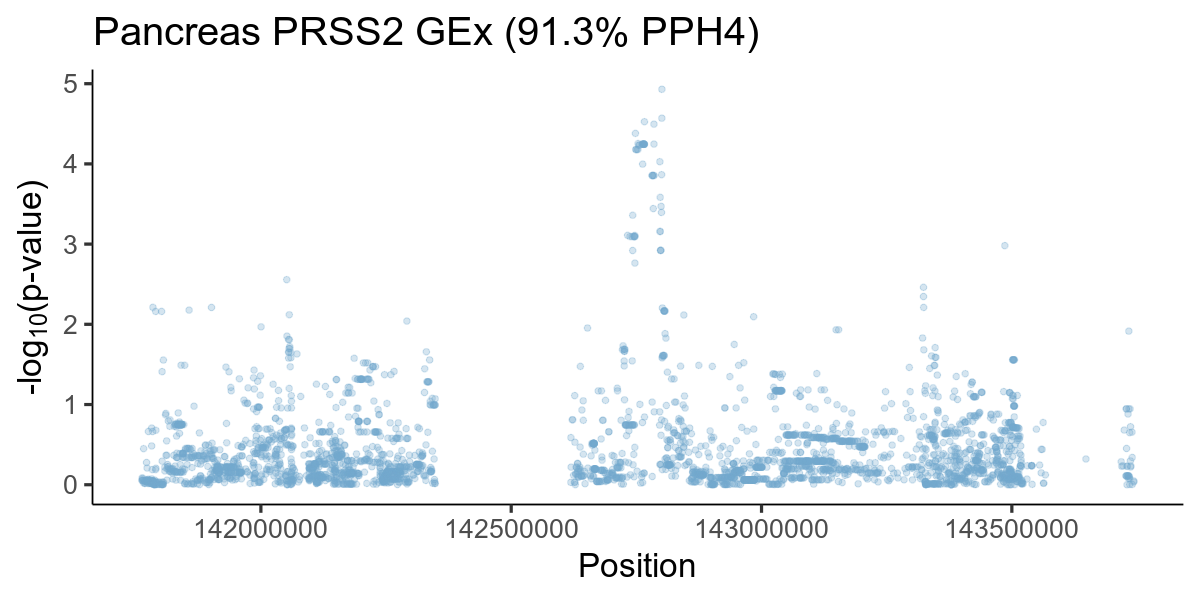

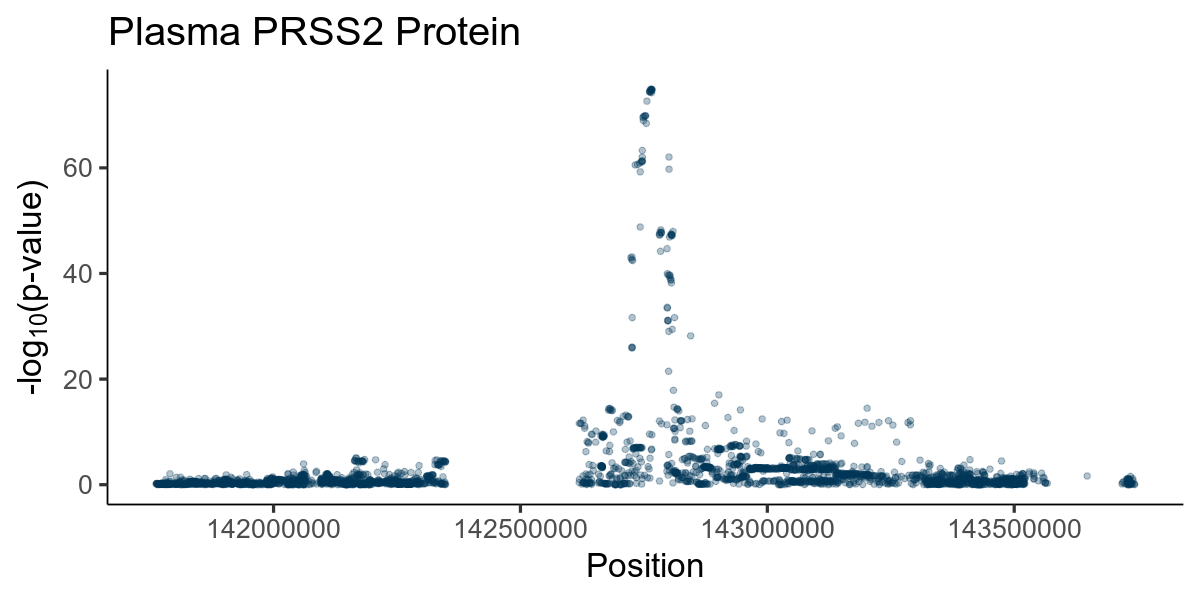

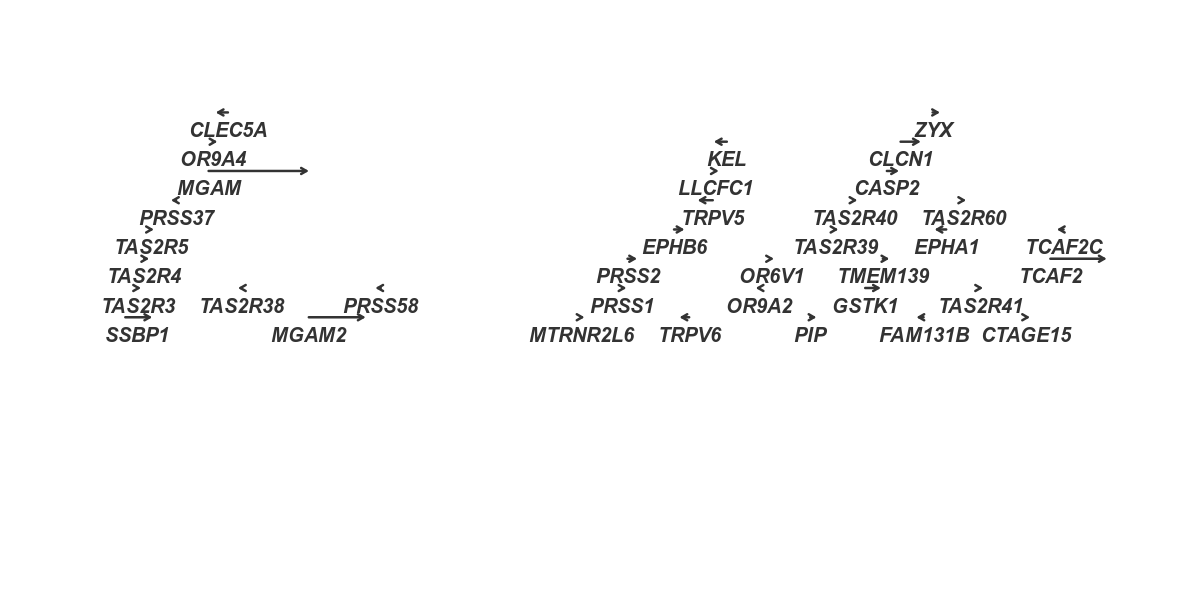

In [133]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(m, aes(x=POS, y=-log10(m$pval_nominal))) + geom_point(col='#74a9cf', alpha = 0.3) + theme_classic(base_size=20) + xlab('Position') + ylab(expression(paste('-log'[10],'(p-value)'))) +theme(axis.line=element_line(size=0.5)) + ggtitle(paste0('Pancreas PRSS2 GEx (', round(coloc_res$summary[6]*100,1), '% PPH4)'))
ggplot(m, aes(x=POS, y=-log10(m$P_VALUE))) + geom_point(col='#023857', alpha = 0.3) + theme_classic(base_size=20) + xlab('Position') + ylab(expression(paste('-log'[10],'(p-value)'))) +theme(axis.line=element_line(size=0.5)) + ggtitle('Plasma PRSS2 Protein')
plot_genes_all(protein_coding[protein_coding$chrom==paste0('chr',m$CHR[1]),], from = min(m$POS), to=max(m$POS), exp=5)

In [3]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/relgamal/miniconda3/envs/R-notebooks/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arrow_14.0.1       susieR_0.12.35     Rfast_2.1.0        RcppParallel_5.1.7
 [5] RcppZiggurat_0.1.6 Rcpp_1.0.12        qqman_0.1.9        tryCatchLog_1.3.1 
 [9] remotes_2.5.0      R.utils_2.12.3     R.o